# Multi-label classification of research papers based on their abstract

## 1. Introduction

### 1.1 Task formulation

We are going to build a multi-label model that can tag research paper abstracts with several appropriate labels, eg. math, physics, finance...

In multi-label classification, classes are not mutually exclusive. Every data set sample can be assigned with multiple labels. For example, one physics research paper may contain advanced mathematical or statistical analysis, therefore should be labeled with physics, math and stat labels.

This problem is supervized text classification problem, so we are going to explore several different classifiers to see which one works best for the given scenario. 


### 1.2 Data acquisition

We used the existing arxiv scraper ([link](https://github.com/Mahdisadjadi/arxivscraper)) to scrape from [arXiv.org](https://arxiv.org/).

Training set consists of ~30000 research papers uploaded to arXiv from 02/01/2018 to 04/01/2018. Test set consists of ~24000 research papers scraped from data uploaded a year later, from 01/01/2019 to 02/01/2019, to minimize the possibility of having same papers in both sets.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
import os
notebook_path = os.path.dirname(os.path.abspath("__file__"))
rel_path = "raw_data/train_data_feb_march_2018.csv"
raw_path = os.path.join(notebook_path,rel_path)

Here is the example of a raw training data. Each entry has several values 

In [51]:
df = pd.read_csv(raw_path)
df.head()

,Unnamed: 0,id,title,subcategories,abstract,doi,created,updated,authors
0,0,704.3504,smooth r\'enyi entropy of ergodic quantum info...,quant-ph cs.it math.it,we prove that the average smooth renyi entropy...,NaN,4/26/2007,NaN,"['schoenmakers', 'tjoelker', 'tuyls', 'verbits..."
1,1,803.257,unequal error protection: an information theor...,cs.it cs.dm math.co math.it,an information theoretic framework for unequal...,10.1109/tit.2009.2032819,3/18/2008,10/25/2009,"['borade', 'nakiboglu', 'zheng']"
2,2,808.0084,on the hitting times of quantum versus random ...,quant-ph cs.ds,in this paper we define new monte carlo type c...,NaN,8/1/2008,NaN,"['magniez', 'nayak', 'richter', 'santha']"
3,3,812.2709,variations on a theme by schalkwijk and kailath,cs.it math.it,schalkwijk and kailath (1966) developed a clas...,10.1109/tit.2009.2034896,12/14/2008,11/20/2009,"['gallager', 'nakiboglu']"
4,4,903.0197,rotation distance is fixed-parameter tractable,cs.ds,rotation distance between trees measures the n...,NaN,3/1/2009,NaN,"['cleary', 'john']"


## 2. Data preprocessing and exploration

Instead of working with given sub-categories, at this point, we are going to identify 7 main categories to work with:
1. computer science (cs)
2. electrical engineering and systems science (eess)
3. matemathics (math)
4. physics (physics)
5. quantitative biology (q-bio)
6. quantitative finance (q-fin)
7. statistics (stat)

Category economy (econ) was underrepresented in both data sets, and is currently excluded from the analysis.

For now, instead of working with sub-categories, we will extract 7 main categories using 'generate_main_categories' function.

Also, there was an issue with the scraper when scraping physics category. For some reason, instead of main_category.subcategory format, it only assignes sub-categories as labels, so we are addressing that problem here as well.

In [52]:
def generate_main_categories(df):
    # Extract main categories from tag strings
    def main_categories(tags):
        main_tags = [i.split(".") for i in tags if i]
        categories = [item[0] for item in main_tags]
        categories = list(set(categories))
        return categories

    # Handling of physics sub-categories'
    def physics_tags(tags):
        physics_categories = ['astro-ph', 'cond-mat', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph', 'hep-th', 'math-ph', 'nlin',
                              'nucl-ex', 'nucl-th', 'physics', 'quant-ph']
        result = ['physics' if item in physics_categories else item for item in tags]
        return list(set(result))

    df['main_categories'] = df['subcategories'].apply(main_categories)
    df['main_categories'] = df['main_categories'].apply(physics_tags)
    
# split subcategories string into list of subcategories
df['subcategories'] = df['subcategories'].str.split()

generate_main_categories(df)

In [54]:
df.head()

,Unnamed: 0,id,title,subcategories,abstract,doi,created,updated,authors,main_categories
0,0,704.3504,smooth r\'enyi entropy of ergodic quantum info...,"[quant-ph, cs.it, math.it]",we prove that the average smooth renyi entropy...,NaN,4/26/2007,NaN,"['schoenmakers', 'tjoelker', 'tuyls', 'verbits...","[cs, math, physics]"
1,1,803.257,unequal error protection: an information theor...,"[cs.it, cs.dm, math.co, math.it]",an information theoretic framework for unequal...,10.1109/tit.2009.2032819,3/18/2008,10/25/2009,"['borade', 'nakiboglu', 'zheng']","[cs, math]"
2,2,808.0084,on the hitting times of quantum versus random ...,"[quant-ph, cs.ds]",in this paper we define new monte carlo type c...,NaN,8/1/2008,NaN,"['magniez', 'nayak', 'richter', 'santha']","[cs, physics]"
3,3,812.2709,variations on a theme by schalkwijk and kailath,"[cs.it, math.it]",schalkwijk and kailath (1966) developed a clas...,10.1109/tit.2009.2034896,12/14/2008,11/20/2009,"['gallager', 'nakiboglu']","[cs, math]"
4,4,903.0197,rotation distance is fixed-parameter tractable,[cs.ds],rotation distance between trees measures the n...,NaN,3/1/2009,NaN,"['cleary', 'john']",[cs]


Now let's have a look at the data set statistics. Here is how many research papers are labeled with exactly one, two or more sub-categories. We see that majority of papers have 1-4 subcategories.

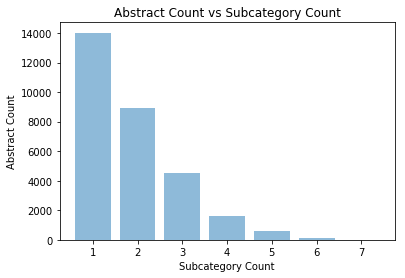

In [56]:
def output_subcategory_stats(df):
    # compute stats
    max_category_count = max(len(x) for x in df['subcategories'])
    category_count_to_abstract_count = [0] * max_category_count
    for categories in df['subcategories']:
        category_count_to_abstract_count[len(categories) - 1] += 1

    # generate bar plot
    category_count_names = [str(x + 1) for x in range(0, max_category_count)]
    y_pos = np.arange(len(category_count_names))
    plt.figure()
    plt.bar(y_pos, category_count_to_abstract_count, align='center', alpha=0.5)
    plt.xticks(y_pos, category_count_names)
    plt.ylabel('Abstract Count')
    plt.xlabel('Subcategory Count')
    plt.title('Abstract Count vs Subcategory Count')

output_subcategory_stats(df)

Here is how many research papers are labeled with exactly one, two or more main categories. We see that majority of papers have between 1 and 3 main categories.

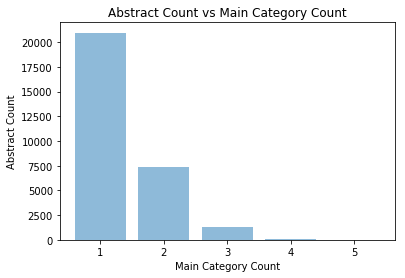

In [58]:
def output_main_category_stats(df):
    # compute stats
    max_category_count = max(len(x) for x in df['main_categories'])
    category_count_to_abstract_count = [0] * max_category_count
    for categories in df['main_categories']:
        category_count_to_abstract_count[len(categories) - 1] += 1
    # generate bar plot
    category_count_names = [str(x + 1) for x in range(0, max_category_count)]
    y_pos = np.arange(len(category_count_names))
    plt.figure()
    plt.bar(y_pos, category_count_to_abstract_count, align='center', alpha=0.5)
    plt.xticks(y_pos, category_count_names)
    plt.ylabel('Abstract Count')
    plt.xlabel('Main Category Count')
    plt.title('Abstract Count vs Main Category Count')

output_main_category_stats(df)

Next, let's look at all possible combinations of main categories on training data set. We see that most papers come from physics, math and computer science. Most common combinations of two labels are: math+physics, cs+math, cs+stat. We also note that the set is fairly unbalanced. We could try to artificially balance the data set later, but for now we can try to get high prediction accuracy over the majority classes, while maintaining reasonable accuracy for the minority classes.

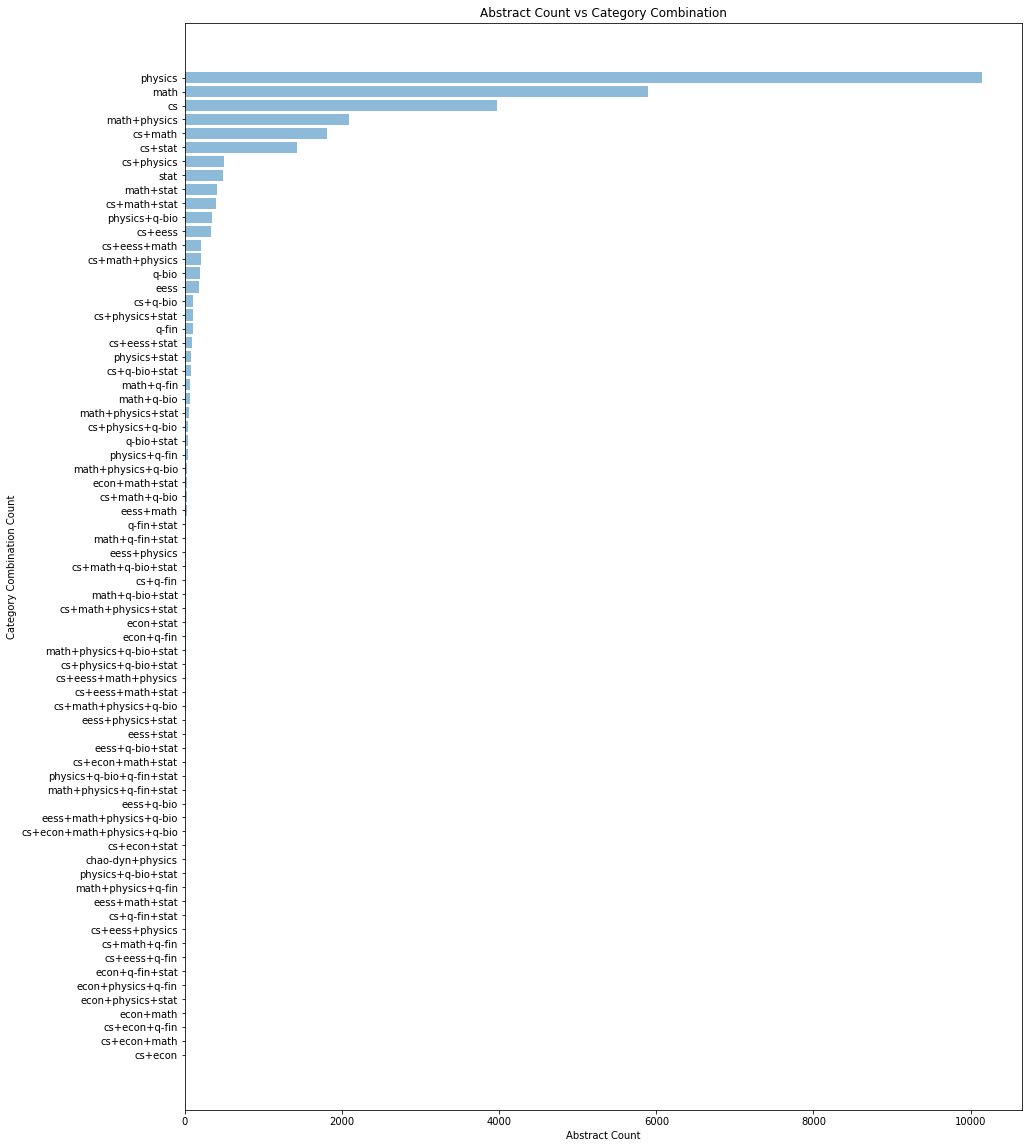

In [60]:
import operator

def output_main_category_tuple_stats(df):
    # compute stats
    category_tuple_to_count = {}
    for categories in df['main_categories']:
        category_tuple = "+".join(sorted(categories))
        if not category_tuple in category_tuple_to_count:
            category_tuple_to_count[category_tuple] = 0
        category_tuple_to_count[category_tuple] += 1

    # generate bar plot
    sorted_items = sorted(category_tuple_to_count.items(), key=operator.itemgetter(1))
    category_tuples = []
    counts = []
    for category_tuple, count in sorted_items:
        category_tuples.append(category_tuple)
        counts.append(count)

    y_pos = np.arange(len(category_tuples))
    plt.figure(figsize=(15, 20))
    plt.barh(y_pos, counts, align='center', alpha=0.5)
    plt.yticks(y_pos, category_tuples)
    plt.xlabel('Abstract Count')
    plt.ylabel('Category Combination Count')
    plt.title('Abstract Count vs Category Combination')
    
output_main_category_tuple_stats(df)

Let's take a peak at the most common words in a data set. For that purpose, we will use the wordcloud.

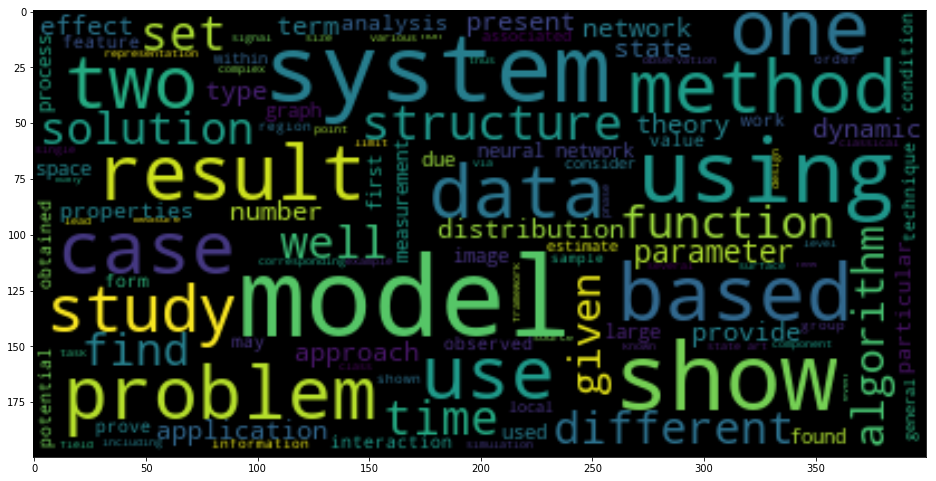

In [61]:
from wordcloud import WordCloud

totalText = ''
for x in df.abstract:
    totalText = totalText + ' ' + x


wc = WordCloud(background_color='black', max_font_size=50).generate(totalText)
plt.figure(figsize=(16, 12))
plt.imshow(wc, interpolation="bilinear")    # mapping integer feature names to original token string

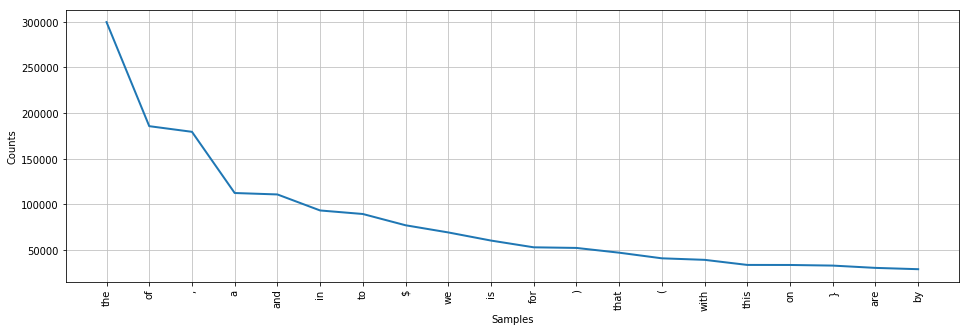

In [66]:
#frequency of the words
import nltk
from nltk.tokenize import ToktokTokenizer

x = nltk.FreqDist(ToktokTokenizer().tokenize(totalText))
plt.figure(figsize=(16,5))
x.plot(20)

We are also going to randomize the data set, so that even when taking smaller samples of data set for testing, we get relativelly equal representation of all categories.

In [65]:
def randomize_dataset(df):
    df_new = df.sample(frac=1).reset_index(drop=True)
    return df_new

df = randomize_dataset(df)

## 3. Text preprocessing

We are going to remove stop words and do the lemmatization. Text is allready lowercase and I'm leaving numbers for now, as we have math, pyhisics, statistics as categories...

In [14]:
#ABSTRACT TEXT PROCESSING
from nltk.corpus import stopwords
stopWordList = stopwords.words('english')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

lemma = WordNetLemmatizer()
token = ToktokTokenizer()

def removeSpecialChars(text):
    str = '`-=~@#$%^&*()_+[!{;”:\’><.,/?”}]'
    for w in text:
        if w in str:
            text = text.replace(w,'')
    return text

def lemitizeWords(text):
    words = token.tokenize(text)
    listLemma =[]
    for w in words:
        x = lemma.lemmatize(w,'v')
        listLemma.append(x)
    text = " ".join(listLemma)
    return text

def stopWordsRemove(text):
    wordList = [x.strip() for x in token.tokenize(text)]
    removedList = [x for x in wordList if not x in stopWordList]
    text =" ".join(removedList)
    return text

def preprocessingText(text):
    text = removeSpecialChars(text)
    text = lemitizeWords(text)
    text = stopWordsRemove(text)
    return text

df['abstract'] = df['abstract'].map(lambda x: preprocessingText(x))

## 4. Text classification

Now we can build our classifier. Since this is a multi-category data, we'll start by using Binary Relevance.

In [13]:
x1 = df['title'].values
x2 = df['abstract'].values
y = y_df.values
x1 = x1[0:5000]
x2 = x2[0:5000]
y = y[0:5000]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cvTitle = CountVectorizer().fit(x1)
title = pd.DataFrame(cvTitle.transform(x1).todense(), columns=cvTitle.get_feature_names())

cvAbstract = CountVectorizer().fit(x2)
abstract = pd.DataFrame(cvAbstract.transform(x2).todense(), columns=cvAbstract.get_feature_names())

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidftitle = TfidfTransformer().fit(title)
tit = pd.DataFrame(tfidftitle.transform(title).todense())

tfidfabs = TfidfTransformer().fit(abstract)
abst = pd.DataFrame(tfidfabs.transform(abstract).todense())

x = pd.concat([tit,abst], axis=1)

In [ ]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y)
classifier = BinaryRelevance(GaussianNB())
classifier.fit(xtrain, ytrain)

In [ ]:
predictions = classifier.predict(xtest.astype(float))
predictions.toarray()

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(ytest[:,0], predictions[:,0])

In [ ]:
for i in range(len(allCategories)):
    print(accuracy_score(ytest[:,i], predictions[:,i]))